# LinkedIn Silverkite  
Silverkite is a model from the greykite package, developed by LinkedIn. It is considered an automated modeling procedure, like Facebook Prophet. It has its own database of holidays it forecasts with and attempts to tune its parameters automatically. The model itself is a type of linear regression with changepoints and regularization.  
In this notebook, the following concepts are covered:  
1. Loading Forecaster objects with external regressors  
2. Forecasting with default silverkite model  
3. Modifying changepoints in silverkite model  
4. Tuning silverkite model  
5. Forecasting on differenced data  
6. Model summaries  

- install greykite: `pip install greykite`  
- read more about grekite: https://engineering.linkedin.com/blog/2021/greykite--a-flexible--intuitive--and-fast-forecasting-library  
- see the [combo](https://scalecast-examples.readthedocs.io/en/latest/combo/combo.html) notebook for an overview of this dataset with EDA  

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster
from scalecast.util import find_optimal_transformation
from scalecast.Pipeline import Pipeline

In [2]:
df = pdr.get_data_fred(['HOUSTNSA','JHDUSRGDPBR'],start='1900-01-01',end='2021-12-31')
df['JHDUSRGDPBR'] = df['JHDUSRGDPBR'].fillna(method='ffill').fillna(0)
f = Forecaster(y=df['HOUSTNSA'],current_dates=df.index)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=756
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

## Prepare Forecast

### Prepare the Recession Indicator
- use as an exogenous regressor

In [3]:
# prepare recession indicator for future
# assume no future recessions in next two years
recessions = df.reset_index()[['DATE','JHDUSRGDPBR']]
fut_recessions = pd.DataFrame({
    'DATE':pd.date_range(
        start=recessions['DATE'].max(),
        periods=25,
        freq='MS'
    ).values[1:],
    'JHDUSRGDPBR':[0]*24}
)
recessions = pd.concat([recessions,fut_recessions])
recessions.tail()

,DATE,JHDUSRGDPBR
19,2023-08-01,0.0
20,2023-09-01,0.0
21,2023-10-01,0.0
22,2023-11-01,0.0
23,2023-12-01,0.0


### Load Object with Parameters and Regressors
- Forecast length: 24 periods (two years)
- Test length: 24 periods
- External recession indicator
- Conformal confidence intervals

In [4]:
f.generate_future_dates(24)
f.set_test_length(24)
f.ingest_Xvars_df(recessions,date_col="DATE") # let the model consider recesssions
f.add_ar_terms(range(24,37)) # we can use direct autoregressive forecasting with silverkite
f.eval_cis()
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=756
    ForecastLength=24
    Xvars=['JHDUSRGDPBR', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36']
    TestLength=24
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Find the optimal set of transformations

In [5]:
transformer, reverter = find_optimal_transformation(
    f,
    estimator='silverkite',
    Xvars = 'all',
    verbose=True,
)

Using silverkite model to find the best transformation set on 1 test sets, each 24 in length.
Last transformer tried:
[]
Score (rmse): 25.001200396713674
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 49.79434396750028
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 29.65330614730279
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (rmse): 51.360030782675594
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 12, 'model': 'add'})]
Score (rmse): 27.629940902996385
--------------------------------------------------
Last transformer tried:
[('Transform', <function find_optimal_transformation.<locals>.boxcox_tr at 0x7fc8f5ba7670>, {'lmbda': -0.5})]
Score (rmse): 34.23912395743547
------------------------

One seasonal difference chosen.

## Apply the silverkite model

In [6]:
silverkite_grid = {
    'changepoints':[2,None],
    'Xvars':[None,'all']
}

In [7]:
def forecaster(f):
    f.set_estimator('silverkite')
    f.ingest_grid(silverkite_grid)
    f.cross_validate(
        k=3,
        verbose=True,
        test_length=24,
    )
    f.auto_forecast()
    matplotlib.use("nbAgg")
    %matplotlib inline

In [8]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

In [9]:
f = pipeline.fit_predict(f)

Num hyperparams to try for the silverkite model: 4.
Fold 0: Train size: 696 (1960-01-01 00:00:00 - 2017-12-01 00:00:00). Test Size: 24 (2018-01-01 00:00:00 - 2019-12-01 00:00:00). 
Fold 1: Train size: 672 (1960-01-01 00:00:00 - 2015-12-01 00:00:00). Test Size: 24 (2016-01-01 00:00:00 - 2017-12-01 00:00:00). 
Fold 2: Train size: 648 (1960-01-01 00:00:00 - 2013-12-01 00:00:00). Test Size: 24 (2014-01-01 00:00:00 - 2015-12-01 00:00:00). 
Chosen paramaters: {'changepoints': 2, 'Xvars': None}.


Now we can see the results plotted.

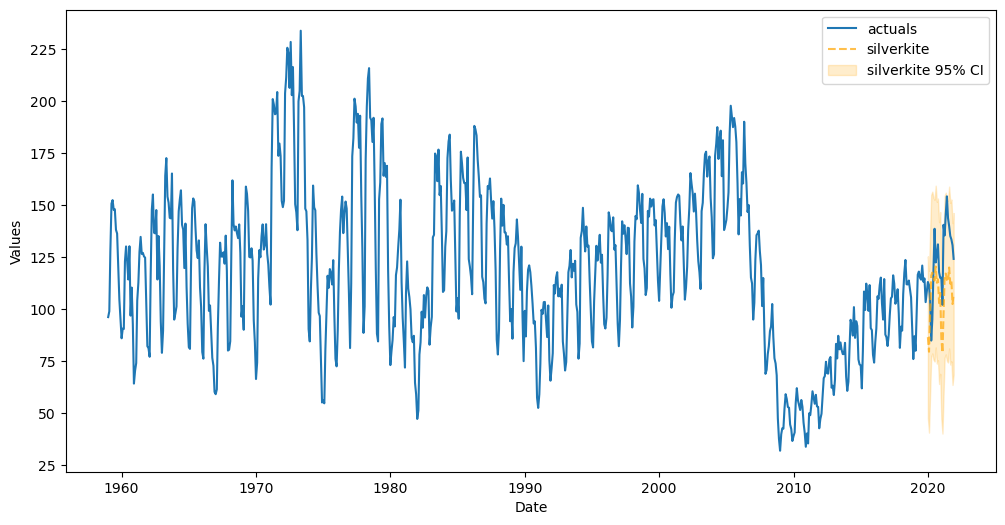

In [10]:
f.plot_test_set(ci=True)
plt.show()

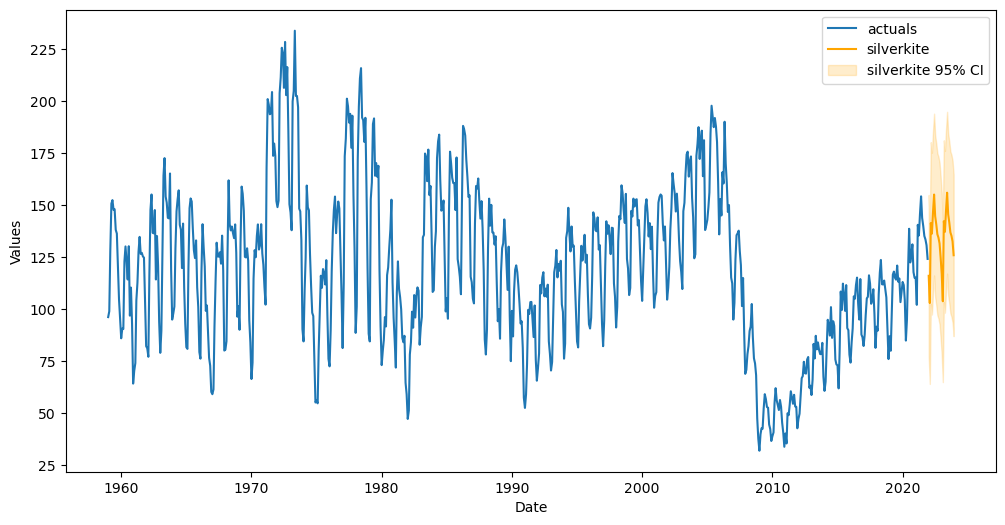

In [11]:
f.plot(ci=True)
plt.show()

Scalecast model summary:

In [12]:
f.export('model_summaries')

,ModelNickname,Estimator,Xvars,HyperParams,Observations,DynamicallyTested,TestSetLength,CILevel,ValidationMetric,ValidationMetricValue,...,weights,best_model,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2
0,silverkite,silverkite,[],{'changepoints': 2},744,True,24,0.95,rmse,11.124548,...,NaN,True,35.682039,0.292353,27.853908,0.124307,24.206223,0.177581,21.884643,-1.097076


Greykite model summary:

In [13]:
f.save_summary_stats()
f.export_summary_stats('silverkite')

,Estimate,Std. Err,Pr(>)_boot,sig. code,95%CI
Pred_col,,,,,
Intercept,-0.627656,1.621083,0.702,,"[-3.8531285086971647, 2.356499683299088]"
"C(Q('events_Chinese New Year'), levels=['', 'event'])[T.event]",0.000442,0.000428,0.300,,"[-0.0002607304049092221, 0.0013420810713082817]"
"C(Q('events_Chinese New Year_minus_1'), levels=['', 'event'])[T.event]",0.000344,0.000542,0.534,,"[-0.0006032882997487039, 0.001518463518762043]"
"C(Q('events_Chinese New Year_minus_2'), levels=['', 'event'])[T.event]",-0.000170,0.000442,0.698,,"[-0.0009151696081354368, 0.0007430782634949848]"
"C(Q('events_Chinese New Year_plus_1'), levels=['', 'event'])[T.event]",0.000464,0.000415,0.268,,"[-0.0001755691414453123, 0.0013656991823609355]"
"C(Q('events_Chinese New Year_plus_2'), levels=['', 'event'])[T.event]",-0.000005,0.000319,0.988,,"[-0.0005955917978176905, 0.0006458427330378518]"
"C(Q('events_Christmas Day'), levels=['', 'event'])[T.event]",0.000000,0.000000,1.000,,"[0.0, 0.0]"
"C(Q('events_Christmas Day_minus_1'), levels=['', 'event'])[T.event]",0.000000,0.000000,1.000,,"[0.0, 0.0]"
"C(Q('events_Christmas Day_minus_2'), levels=['', 'event'])[T.event]",0.000000,0.000000,1.000,,"[0.0, 0.0]"
